In [1]:
%matplotlib inline
import librosa
import matplotlib.pyplot as plt
from units import unit
import numpy as np
second = unit('s')
Frames = unit('Frames')

In [2]:
input_path = 'sample.wav'
ear_time_resolution = second(0.01)
ear_frame_rate = 1.0 / ear_time_resolution
print 'Ear frame rate:', ear_frame_rate
hop_length = int(ear_frame_rate * second(1.0))
print 'Hop length:', hop_length

Ear frame rate: 100.00 1 / s
Hop length: 100


In [3]:
data, sr = librosa.load(input_path)
total_length = second(float(len(data)) / float(sr))
number_of_frames = int(total_length / ear_time_resolution)
print 'Total time: %s (%d frames)' % (total_length, number_of_frames)

def show_time_ticks():
    ticks = np.arange(second(0.0), total_length, second(1.0)) / second(1.0)
    librosa.display.time_ticks(ticks * prepared_data.shape[1] / (total_length / second(1.0)), ticks)

Total time: 13.81 s (1381 frames)


In [4]:
stft_data = librosa.stft(data, hop_length=hop_length)

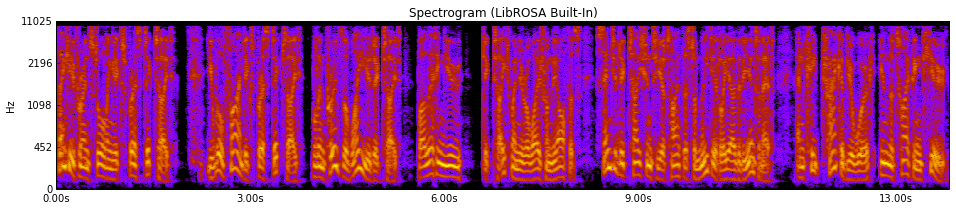

In [5]:
plt.figure(figsize=(16, 3))
plt.title('Spectrogram (LibROSA Built-In)')
prepared_data = librosa.logamplitude(np.abs(stft_data)**2, ref_power=np.max)
lf_space = 1.0 - np.logspace(0.0, -np.log2(prepared_data.shape[0]), num=prepared_data.shape[0], base=2.0)
librosa.display.specshow(prepared_data, y_axis='log', cmap='gnuplot')
show_time_ticks()
plt.show()

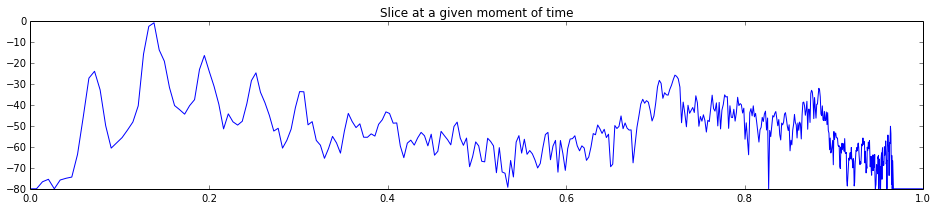

In [6]:
t = 1330
plt.figure(figsize=(16, 3))
plt.plot(lf_space, prepared_data[:,t])
plt.title('Slice at a given moment of time')
plt.show()

Now we have plots of slices. We would like to invent a metrics on them. Let's use a weighted Euclidian metrics. Suppose we have two frames $F_a(\nu)$ and $F_b(\nu)$ where $\nu$ is a frequency. Then the metrics will be:

$$
d(F_a, F_b) = \left(
  \int_{0}^{\infty} \left|F_a(\nu) - F_b(\nu)\right|^{2} d \nu
\right)^{(1/2)}
$$

However, as we only have $F(\nu)$ known only for a finite set of frequencies $\nu_k \in \left(0, 1, 2, ..., N\right)$ then we must adjust integral to use weights of those values. Therefore:

$$
d_{discrete}(F_a, F_b) = \left(
  \sum_{k=0}^{N-1} \left|F_a(\nu_k) - F_b(\nu_k)\right|^2 \times (\log(\nu_{k+1}) - \log(\nu_k))
\right)^{1/2}
$$


In [7]:
lf_space_diff = np.ediff1d(lf_space, to_end=0.0)

def d_discrete(a, b):
    return np.sum(np.abs(a - b)**2 * lf_space_diff)**0.5

Let's try to find repeating sequences of similar sounds. To do so, we want to pre-compute all distances between a pairs of frames.

In [10]:
def cache_d_discrete():
    result = []
    for a in xrange(0, prepared_data.shape[1]):
        result.append([
            d_discrete(prepared_data[:,a], prepared_data[:,b])
            for b in xrange(0, a)
        ] + [0.0])
        for b in xrange(0, a):
            result[b].append(result[a][b])
    return np.array(result)
    
_d_discrete = cache_d_discrete()
print _d_discrete.shape

(3046, 3046)


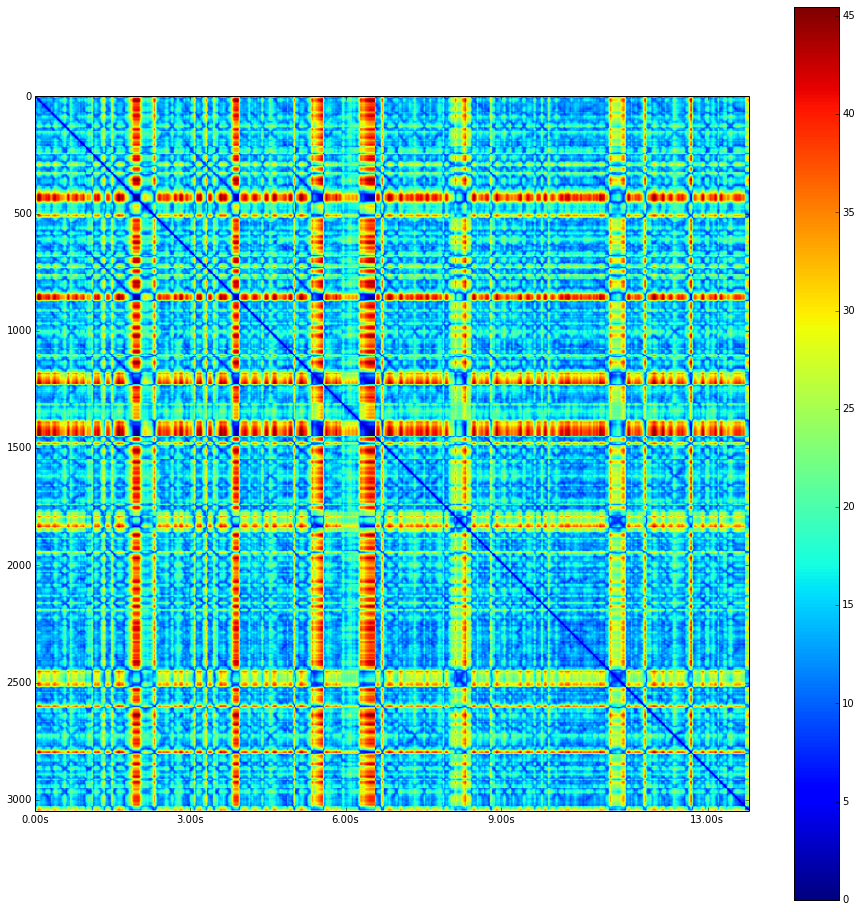

In [11]:
plt.figure(figsize=(16, 16))
img = plt.imshow(_d_discrete, interpolation='none')
plt.colorbar(img)
show_time_ticks()
plt.show()

For the initial screening the data should be splitted into chunks in order to be able to calculate $d_{discrete}$. Each chunk will be 10 seconds in length. The output will consists of blocks of size $1000 \times 1000$ frames, $\approx8Mb$ per frame. Given 3600 seconds of records, the estimated number of blocks will be $10^5$ and the estimated raw data volume will be $\approx1Tb$.

Interface: **(a.wav, b.wav) -> a-b.bin**

Though application will calculate simple Euclidean distance, it should be possible to add another metrices as more suitable distances can possibly found in a future.

In [ ]:
values = [int(v) for vv in _d_discrete for v in vv]
bins = [0] * (int(max(values)) - int(min(values)) + 1)
for v in values:
    bins[int(v)] += 1

plt.figure(figsize=(16, 3))
plt.plot(np.arange(int(min(values)), int(max(values)) + 1, 1), bins)
plt.show()

Assumptions:
1. Language has a limited set of sounds. That sounds are not directly mapped onto written language symbols. Also, some sounds are mistakenly treated as a single sound even by native speakers. Despite that using a wrong sound can probably be detected unconsiousnally.
2. Any language part will be repeated at least several times given enough raw data.

As a first step, we will try to find all repeating sequencies with a length of $0.7$ of an average word (for now $0.3 sec$).

That we will try to match the sequencies. Suppose we have a set of such recognized sequencies $S_{r(ecognized)}$. Than upon receiving any sequence $s_{new}$ we should search through all $s_{r} \in S_{r}$ for $s_{r}$ has intersection with $s_{new}$. If it is found than $s_{r}$ should be removed from $S_{r}$ and replaced with some parts fo $s_{r}$ and $s_{new}$.

In [ ]:
sequence_length = 70
sequence_distances = np.array([
    [
        sum(_d_discrete[a + k,b + k] for k in xrange(sequence_length)) / float(sequence_length)
        for b in xrange(_d_discrete.shape[1] - sequence_length)
    ]
    for a in xrange(_d_discrete.shape[0] - sequence_length)
])
sequence_distances.shape

In [ ]:
plt.figure(figsize=(16, 16))
plt.imshow(sequence_distances)
plt.colorbar()
plt.axvline(1145, color='black')
plt.axhline(365, color='black')
plt.show()

In [ ]:
average_sequence_distances = np.sum(sequence_distances, axis=1) / float(sequence_distances.shape[1])
average_sequence_distance_10_percentile = np.percentile(average_sequence_distances, 10)
plt.figure(figsize=(16, 3))
plt.axhline(average_sequence_distance_10_percentile, color='black')
plt.plot(average_sequence_distances)
plt.show()

In [ ]:
c = 0.6
similarity_threshold = c * average_sequence_distance_10_percentile
below_threshold = np.array([
    [
        (sequence_distances[a,b] if sequence_distances[a,b] < similarity_threshold else average_sequence_distance_10_percentile * 2.0)
        for b in xrange(sequence_distances.shape[1])
    ]
    for a in xrange(sequence_distances.shape[0])
])

plt.figure(figsize=(16, 16))
plt.imshow(below_threshold)
plt.colorbar()
plt.show()

Now we just want to find significant local minumums.

In [ ]:
plt.figure(figsize=(16, 3))
plt.title('LibROSA Built-In')
prepared_data = librosa.logamplitude(np.abs(stft_data)**2, ref_power=np.max)
lf_space = 1.0 - np.logspace(0.0, -np.log2(prepared_data.shape[0]), num=prepared_data.shape[0], base=2.0)
[plt.axvline(t, color='white') for (t, v) in enumerate(dd[2010]) if v < 10.0]
librosa.display.specshow(prepared_data, y_axis='log', cmap='gnuplot')
plt.show()

In [ ]:
threshold = 10.0
clusters = []
processed = set()
for t_a, row in enumerate(dd):
    if t_a in processed:
        continue
    cluster = []
    for t_b in xrange(t_a, len(dd)):
        if dd[t_a][t_b] < threshold:
            cluster.append(t_b)
    map(processed.add, cluster)
    clusters.append(cluster)
print len(clusters)

clustering = {x: k for (k, cluster) in enumerate(clusters) for x in cluster}

plt.figure(figsize=(16, 3))
plt.title('LibROSA Built-In')
prepared_data = librosa.logamplitude(np.abs(stft_data)**2, ref_power=np.max)
lf_space = 1.0 - np.logspace(0.0, -np.log2(prepared_data.shape[0]), num=prepared_data.shape[0], base=2.0)
for t in xrange(len(dd)):
    plt.axvline(t, color=str(clustering[t] / float(len(clusters))), alpha=0.3)
librosa.display.specshow(prepared_data, y_axis='log', cmap='gnuplot')
plt.show()


In [ ]:
lens = [len(cluster) for cluster in clusters]

plt.figure()
plt.plot(lf_space, np.average([prepared_data[:,t] for t in clusters[20]], axis=0))
plt.plot(lf_space, np.average([prepared_data[:,t] for t in clusters[25]], axis=0))
plt.show()